# Chapter 2

<a target="_blank" href="https://colab.research.google.com/github/CausalAILab/causalai-book/blob/main/chapter2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import os
import sys

if 'google.colab' in sys.modules:
    os.system("wget -O scm.py https://raw.githubusercontent.com/CausalAILab/causality-book/main/scm.py")

In [2]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sympy import symbols

from IPython.display import Latex

from scm import SymbolicSCM

print(sys.version)

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]



# Definition 2.1.1 - Structural Causal Model (SCM).

A structural causal model $M$ is a 4-tuple $\langle \mathbf U, \mathbf V, F, P(\mathbf U)\rangle$, where

- $\mathbf U$ is a set of background variables, also called exogenous variables, that are determined by factors outside the model;
- $\mathbf V$ is a set $\{V_1, \dots V_n\}$ of variables, called endogenous, that are determined by other variables in the model — that is, variables in $\mathbf U \cup \mathbf V$.
- $F$ is a set of functions $\{f_1, \dots f_n\}$ such that each $f_i$ is a mapping from (the respective domains of) $U_i \cup \mathbf{Pa}_i$ to $V_i$, where $U_i \subseteq \mathbf U, \mathbf{Pa}_i \subseteq \mathbf V \setminus V_i$, and the entire set $F$ forms a mapping from $\mathbf U$ to $\mathbf V$. That is, for $i = 1, \dots, n$, each $f_i \in F$ is such that

$$v_i \gets f_i(\mathbf{pa}_i, \mathbf{u}_i)$$

i.e., it assigns to a value to $V_i$ that depends on (the values of) a select set of variables in $\mathbf U \cup \mathbf V$; and

- $P(\mathbf U)$ is a probability function defined over the domain of $\mathbf U$.

## Example 2.1
Consider a game of chance described through the SCM $M^1 = \langle \mathbf U = \{U_1, U_2\}, \mathbf V = \{X, Y\}, F, P(U_1, U_2)\rangle$, where

$$F = \begin{cases}
X &\gets U_1 + U_2 \\
Y &\gets U_1 - U_2
\end{cases}$$

and $P(U_i = k) = 1/6$; $i = 1,2$; $k = 1, \dots, 6$.

In [3]:
x, y, u1, u2 = symbols('x y u1 u2')

m1 = SymbolicSCM(
    f={
        x: u1 + u2,
        y: u1 - u2,
    },
    pu={
        # each list characterizes a categorical distribution
        # the first element is the probability of the value 0
        u1: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
        u2: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
    }
)
m1

SCM([x, y], [u1, u2])

In [4]:
m1.get_probability_table(include_u=True).head()

,u1,u2,x,y,probability
0,1,1,2,0,0.027778
1,1,2,3,-1,0.027778
2,1,3,4,-2,0.027778
3,1,4,5,-3,0.027778
4,1,5,6,-4,0.027778


In [5]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


First, we plot an empirical histogram of each variable's using $10^6$ samples drawn from its distribution.

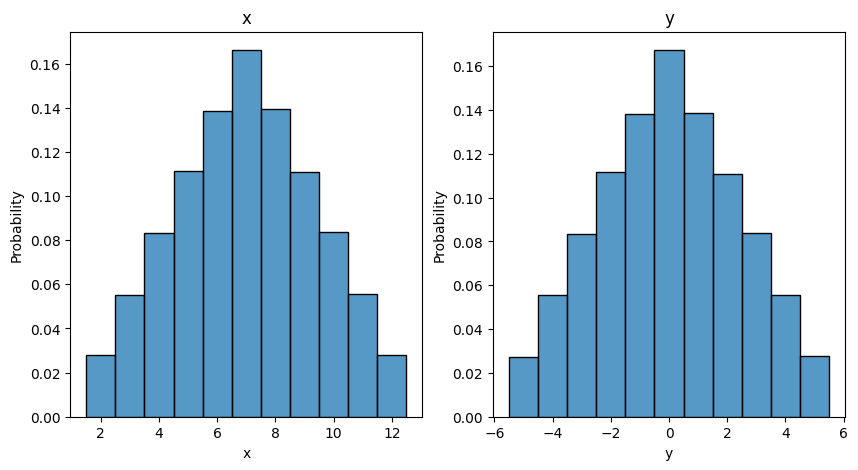

In [6]:
sample = m1.sample(n=10**6)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(sample[x], label='x', ax=axes[0], discrete=True, stat="probability")
axes[0].set_title('x')   
sns.histplot(sample[y], label='y', ax=axes[1], discrete=True, stat="probability")
axes[1].set_title('y')
plt.show()

Then, we compute the joint distribution of $X, Y$. We are able to do so in closed form, given that all variables are discrete.

In [7]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


Text(0.5, 1.0, 'Joint distribution of x and y')

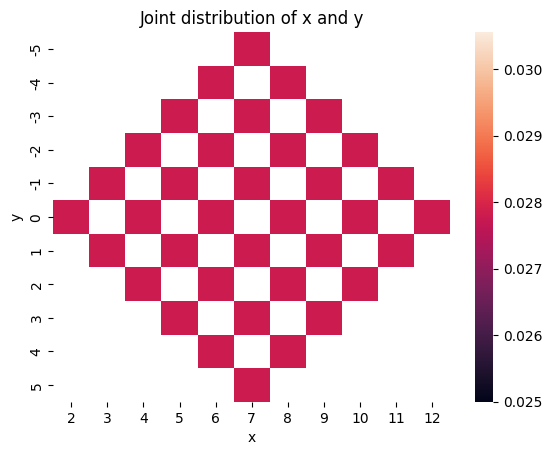

In [8]:
sns.heatmap(pd.pivot(m1.get_probability_table(), index=y, columns=x, values='probability'))
plt.title('Joint distribution of x and y')

# Definition 2.2.1 - Layer 1 Valuation - "Observing"

An SCM $M = \langle \mathbf U, \mathbf V, F, P(\mathbf U)\rangle$ defines a joint probability distribution $P^M(\mathbf V)$ such that for each $\mathbf Y \subseteq \mathbf V$:

$$P^M(\mathbf y) = \sum_\mathbf u \mathbf 1[\mathbf Y(\mathbf u) = \mathbf y] P(\mathbf u)$$

where $Y(\mathbf U)$ is the solution for $\mathbf Y$ after evaluating $F$ with $\mathbf U = \mathbf u$.

# Example 2.2

Consider the following SCM, where the observed variables represent a specific treatment $X$ (e.g., administering a drug), an outcome $Y$ (e.g., survival), and the presence or absence of a symptom $Z$ (e.g., hypertension). The exogenous variables consist of natural resistance to the disease $U_r$ and other unknown sources of variation $U_x, U_y, U_z$.

$$
M^2 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_r, U_x, U_y, U_z\}\\
    F &= \begin{cases}
        Z := \mathbf 1[U_r = 1, U_z = 1]\\
        X := \mathbf 1[Z = 1, U_x = 1] + \mathbf 1[Z = 0, U_x = 0]\\
        Y := \mathbf 1[X = 1, U_r = 1] + \mathbf 1[X = 0, U_r = 1, U_y = 1] + \mathbf 1[X = 0, U_r = 0, U_y = 0]\\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_r &\sim \mathrm{Bern}(0.25) \\
       U_z &\sim \mathrm{Bern}(0.95) \\
       U_x &\sim \mathrm{Bern}(0.9) \\
       U_y &\sim \mathrm{Bern}(0.7) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [9]:
z, x, y, ur, uz, ux, uy = symbols('z x y ur uz ux uy')

m2 = SymbolicSCM(
    f={
        z: ur & uz,
        x: z & ux | ~z & ~ux,
        y: x & ur | ~x & ur & uy | ~x & ~ur & ~uy,
    },
    pu={
        ur: 0.25,
        uz: 0.95,
        ux: 0.9,
        uy: 0.7,
    }
)
m2

SCM([z, x, y], [ur, uz, ux, uy])

In [10]:
m2.get_probability_table()

,z,x,y,probability
0,0,0,0,0.475875
1,0,0,1,0.210375
2,0,1,0,0.075000
3,0,1,1,0.001250
4,1,0,0,0.007125
5,1,0,1,0.016625
6,1,1,1,0.213750


## Example 2.3 (2.2 cont.)

We can reproduce Table 2.2 in the textbook by setting `u = True` to also display exogenous variables:

In [11]:
m2.get_probability_table(include_u=True)

,ur,uz,ux,uy,z,x,y,probability
0,0,0,0,0,0,1,0,0.001125
1,0,0,0,1,0,1,0,0.002625
2,0,0,1,0,0,0,1,0.010125
3,0,0,1,1,0,0,0,0.023625
4,0,1,0,0,0,1,0,0.021375
5,0,1,0,1,0,1,0,0.049875
6,0,1,1,0,0,0,1,0.192375
7,0,1,1,1,0,0,0,0.448875
8,1,0,0,0,0,1,1,0.000375
9,1,0,0,1,0,1,1,0.000875


We may evaluate $P(Y = 1 | X = 1)$ as $P(Y = 1, X = 1) / P(X = 1)$ using Bayes' rule by directly querying the probability table, a pandas DataFrame.

In [12]:
pt = m2.get_probability_table()
pt.query('x == 1 and y == 1').probability.sum() / pt.query('x == 1').probability.sum()

0.7413793103448276

For convenience, we implement the equivalent `SCM.query` to compute queries.

In [13]:
m2.query({y: 1}, given={x: 1})

0.7413793103448275

The `latex` flag causes the function to output the query and value in LaTeX.

In [14]:
m2.query({y: 1}, given={x: 1}, latex=True)

<IPython.core.display.Latex object>

In [15]:
m2.query({y: 1}, given={x: 0}, latex=True)

<IPython.core.display.Latex object>

In [16]:
m2.query({z: 1}, latex=True)

<IPython.core.display.Latex object>

# Definition 2.2.2 - Submodel - "Interventional SCM"

Let $M$ be a causal model, $\mathbf X$ a set of variables in $\mathbf V$, and $\mathbf x$ a particular realization of $\mathbf X$. A submodel $M_\mathbf x$ of $M$ is the causal model

$$M_\mathbf x = \langle \mathbf U, \mathbf V, F_\mathbf x, P(\mathbf U)\rangle,$$

where

$$F_\mathbf x = \{f_i : V_i \not\in \mathbf X\} \cup \{\mathbf X \gets \mathbf x\}$$

## Definition 2.2.3 - Potential Response, Potential Outcome

Let $\mathbf X$ and $\mathbf Y$ be two sets of variables in $\mathbf V$ and $\mathbf u$ be a unit. The potential response $\mathbf Y_\mathbf x (\mathbf u)$ is defined as the solution for $\mathbf Y$ of the set of equations $F_\mathbf x$ with respect to SCM $M$ - for short, $\mathbf Y_{M_\mathbf x}(\mathbf u)$. That is,

$$\mathbf Y_\mathbf x(\mathbf u) = \mathbf Y_{M_\mathbf x}(\mathbf u).$$

## Definition 2.2.4 - Layer 2 Valuation - "Intervening"

An SCM $M =  \langle \mathbf U, \mathbf V, F, P(\mathbf U)\rangle$ induces a family of joint distributions over $\mathbf V$, one for each intervention $\mathbf x$. For each $\mathbf Y \subset \mathbf V$:

$$P^M(\mathbf y _ \mathbf x) = \sum_\mathbf u \mathbf 1[\mathbf Y_\mathbf x (\mathbf u) = \mathbf y] P(\mathbf u)$$

## Definition 2.2.5 - Effectiveness

A joint interventional distribution $P(\mathbf v | do(\mathbf x))$ is said to satisfy *effectiveness* if for every $V_i \in \mathbf X$,

$$P(v_i | do(\mathbf x)) = 1 \text{ if $v_i$ is consistent with $\mathbf x$ and $0$ otherwise.}$$

*Note: every interventional distribution satisfies effectiveness.*

## Example 2.4 (2.1 cont.)

Consider the SCM in Example 2.1.

In [17]:
m1

SCM([x, y], [u1, u2])

In [18]:
m1.query({y: 0}, latex=True)

<IPython.core.display.Latex object>

If we intervene on $X$, setting $X = 2$, it is evident $Y$ will not change, because it does not depend on $X$. We can see this when we replace the function for $X$ with $X = 2$.

Note that all observed variables in the interventional submodel $M_{X = 2}$ now have a subscript; the unobserved variables are unaffected by the intervention and do not change.

In [19]:
m1.do({x: 2})

SCM([{x}_{x=2}, {y}_{x=2}], [u1, u2])

In [20]:

val = m1.do({x: 2}).query({y: 0})

Latex(f'$P(y = 0 | do(x = 2)) \\approx {val:.4f}$')

<IPython.core.display.Latex object>

We are slightly abusing notation with the above expression. If we wished to be mathematically precise, we would note that we are actually querying the probability of the event $P(Y_{X = 2} = 0)$ rather than $P(Y = 0)$.

The Python data structure underlying the interventional SCM $M_{X = 2}$ has an internal mapping from the symbol $Y$ to $Y_{X = 2}$, which allows the above query to work.

The slightly more verbose - but precise - formulation of the above expression follows:

In [21]:
m1_x2 = m1.do({x: 2})
x2, y2 = m1_x2.v
m1_x2

SCM([{x}_{x=2}, {y}_{x=2}], [u1, u2])

In [22]:
m1_x2.query({y2: 0}, latex=True)

<IPython.core.display.Latex object>

We also implement a convenience mapping in $\mathcal M^1$ which remembers that $Y_{X=1}$ is derived from an intervention on $\mathcal M^1$ and allows us to write the following expression:

In [23]:
m1.query({y2: 0}, latex=True)

<IPython.core.display.Latex object>

## Example 2.5 (2.2 cont.)

Next, we consider **treatment effects**. What is the effect of treatment $X$ on medical outcome $Y$?

Can we just look at the observational quantity $P(Y = 1 | X = 1) - P(Y = 1 | X = 0)$ to make a decision on whether or not to apply the treatment?

In [24]:
val = m2.do({x: 1}).query({y: 1})

Latex(f'$P(y = 1 | do(x = 1)) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

In [25]:
val = m2.query({y: 1}, given={x: 1}) - m2.query({y: 1}, given={x: 0})
Latex(f'$P(y=1 | x=1) - P(y=1 | x=0) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

The total variation of X on Y is positive. So should we enforce the treatment $X = 1$?

Let's compare this difference to the **average treatment effect**, $P(Y = 1 | do(X = 1)) - P(Y = 1 | do(X = 0))$. This represents the difference between control and treatment group in a randomized controlled trial, where treatment assignment is randomized.

In [26]:
val = m2.do({x: 1}).query({y: 1}) - m2.do({x: 0}).query({y: 1})
Latex(f'$P(y=1 | do(x=1)) - P(y=1 | do(x=0)) \\approx {val:.4g}$')

<IPython.core.display.Latex object>

We can see that if we enforce the treatment, $do(X = 1)$, we will actually end up harming the population more than we help it.

# Definition 2.2.6 - Layer 3 Valuation

An SCM $M = \langle\mathbf U, \mathbf V, F, P(\mathbf U)\rangle$ induces a family of joint distributions over counterfactual events $\mathbf Y_\mathbf x, \dots, \mathbf Z_\mathbf w$ for any $\mathbf Y, \mathbf Z, \dots, \mathbf X, \mathbf W \subseteq \mathbf V$:

$$P^M(\mathbf y_\mathbf x, \dots, \mathbf z_\mathbf w) = \sum_\mathbf u \mathbf 1[\mathbf Y_\mathbf x(\mathbf u) = \mathbf y, \dots, \mathbf Z_\mathbf w(\mathbf u) = \mathbf z] P(\mathbf u)$$

## Example 2.6 (Example 2.2, cont.)

We now introduce notation for counterfactual ($L_3$) queries in code.

Say we are interested in knowing whether or not the treatment $do(X = 1)$ would have saved patients who died and did not receive the treatment ($Y = 0, X = 0$).

The variable of interest is $Y_{X = 1}$ in the SCM $M_{X=1}$, since we are hypothetically forcing the patient to take the treatment.

In [27]:
m2

SCM([z, x, y], [ur, uz, ux, uy])

In [28]:
z1, x1, y1 = m2.do({x: 1}).v
y1

{y}_{x=1}

However, the information we have is from the actual world $M$: $X = 0, Y = 0$. We write our expression as

$$P(Y_{X = 1} = 1 | X = 0, Y = 0)$$

 to describe the question: "What is the probability that the patient would have survived if they had taken the drug, given that they did not take the drug and died?"

 We may represent this query using the `y1` variable defined above from $M_{X=1}$.

In [29]:
m2.query({y1: 1}, given={x: 0, y: 0}, latex=True)

<IPython.core.display.Latex object>

# Definition 2.4.1 -- Causal Diagram

Consider an SCM $M$ = ($U, V, F, P(U)$). Then $G$ is said to be a **causal diagram** (of M) if constructed as follows:

(1) add a vertex for every endogenous variable in the set $V$

(2) add a directed edge ($V_j \rightarrow V_i$) for every $V_i, V_j \in V$ if $V_j$ appears as an argument of $f_i \in F$

(3) add a bidirected edge ($V_j \leftarrow \rightarrow V_i$) for every $V_i, V_j \in V$ if: the corresponding $U_i, U_j \in U$ are correlated, or the corresponding functions $f_i, f_j$ share some $U_{ij} \in U$ as an argument

In [30]:
from causal_graph import CausalGraph

from IPython.display import display

# ! brew install graphviz
# Must install to view graphs

In [31]:
x, y, z = symbols('x y z')

graph = CausalGraph([x,y,z], directed_edges=[(z,x), (x, y)],
                    bidirected_edges=[(z,y)])

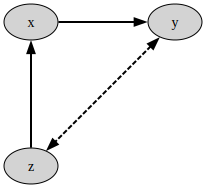

In [32]:
graph.draw(node_positions={x: (0, 2), y: (2,2), z: (0, 0)})

# Definition 2.4.3 -- d-separation

Consider a causal diagram $G$ and disjoint sets of endogenous variables $X,Y,Z$. A path between $x \in X$ and $y \in Y$ in $G$ is blocke dby $Z$ if and only if:

1. $p$ contains a chain $A \rightarrow B \rightarrow C$ or a fork $A \leftarrow B \rightarrow C$ such that the middle node is in $Z$, **or**
   
2. $p$ contains a collider $A \rightarrow B \leftarrow C$ such that the collision node $B$ or any of its descendants is not in $Z$


if $Z$ blocks every path between $x \in X$ and $y \in Y$ in $G$, then the pair $X,Y$ is said to be **d-separated** (or "closed") given $Z$.


Consider the following causal diagram describing the relation between the variables Climate (C), Sprinkler (S), Rain (R), Wet (W), and Slippery (L).

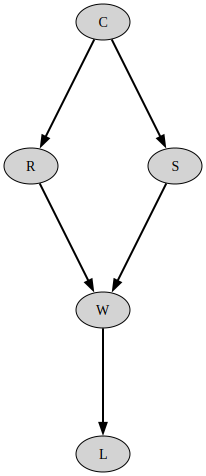

In [33]:
C, S, R, W, L = symbols('C S R W L')

graph = CausalGraph([C, S, R, W, L], directed_edges=[(C, S), (C, R), (R, W), (S,W), (W, L)])

graph.draw(node_positions={C: (0, 0), S: (1,-2), R: (-1,-2), W: (0, -4), L: (0, -6)})

## Example 2.15

Consider the causal diagram and whether S is d-separated from W. In thise case $X = {S}, Y={W}, Z= \emptyset$.

To evaluate this query, there are two paths to consider, namely, $p_1: S \rightarrow W, p_2: S \leftarrow C \rightarrow R \rightarrow W$.

$p_1$ is unblockable due to the direct connection, and technically this would be sufficient to conclude $S$ and $W$ are not d-separated.

We continue with this exercise with the second path $p_2$ to better understand the criterion. The evaluation goes triplet by triplet:

The first segment we evaluate is $p_2^1: S \leftarrow C \rightarrow R$, which is unblocked since it's a chain and $C \notin Z$, and the second segment $p_2^2: C \rightarrow R \rightarrow W$ is also unblocked for the same reason, $R \notin Z$.

Given that there exists an unblocked path (actually two) between S and W, those variables are not d-separated.

In [34]:
graph.is_d_separator(x=S, y=W, given={})

False

In [35]:
graph.find_all_d_separators(x=S, y=W)

[]

## Example 2.16

Now consider the question of whether R and L are d-separated in the causal diagram given W. In this case, $X = {R}, Y = {L}, Z = {W}$.

There are two paths to consider:
  
$p_1: R \rightarrow W \rightarrow L$ and $p_2: R \leftarrow C \rightarrow S \rightarrow W \rightarrow L$.

The first path, which consists of a single triplet (a chain), is closed since $W \in Z$.

The second path is divided into three segments:  
$p_1^2: R \leftarrow C \rightarrow S$,  
$p_2^2: C \rightarrow S \rightarrow W$, and  
$p_3^2: S \rightarrow W \rightarrow L$.

The first segment, $p_1^2$, is unblocked because it's a fork and $C \notin Z$.  
The second segment, $p_2^2$, is unblocked since it's a chain and $S \notin Z$.  
However, the third segment, $p_3^2$, is blocked because it's a chain and $W \in Z$.

Thus, the second path, $p_2$, is blocked because at least one of its triplets obstructs the flow of information.  
After all, there is no flow of information between $R$ and $L$ when conditioning on $W$, so they are d-separated.

In [36]:
graph.is_d_separator(x=R, y=L, given={W})

True

In [37]:
graph.find_all_d_separators(x=R,y=L)

[{W}, {S, W}, {C, W}, {C, S, W}]

## Example 2.18 -- d-separation in non-Markovian models

Consider the following causal diagram:

In [38]:
t, x, w, z, r, y, s = symbols('t x w z r y s')

graph = CausalGraph([t, x, w, z, r, y, s], directed_edges=[(t,x), (t,z), (x,w), (w,z), (z,y), (r,y), (y,s)],
                    bidirected_edges=[(w,y)])

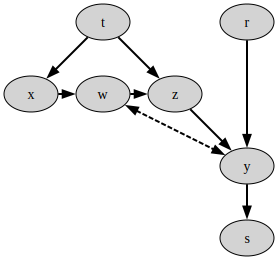

In [40]:
graph.draw(node_positions={t: (1, 1), x: (0, 0), w: (1,0), z: (2,0), r: (3,1), y: (3,-1), s: (3,-2)})